In [2]:
import numpy as np
import gstools as gs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import seaborn as sns

x = np.linspace(0, 25, 25)
y = np.linspace(0, 25, 25)
XX, YY = np.meshgrid(x, y)
#第一个数据

model = gs.Gaussian(dim=2, var=1,len_scale=3)
srf = gs.SRF(model,mean=0.)
srf((x, y), mesh_type='structured')
B0=srf((x, y), mesh_type='structured',seed=100)

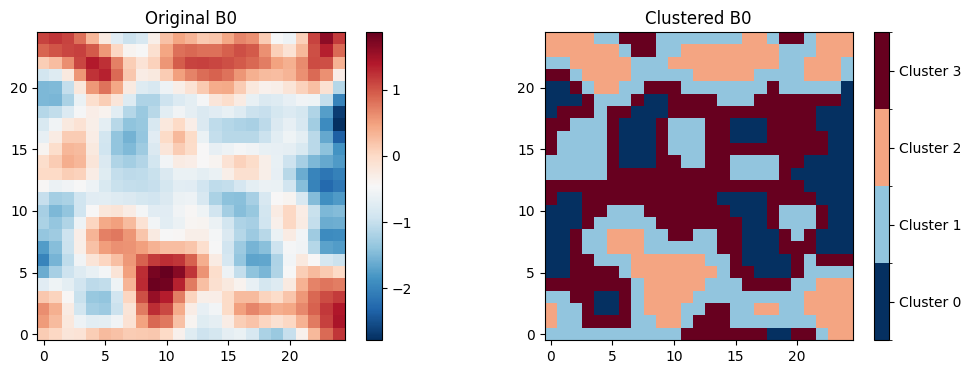

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [64]:


# 将B0转换为适合聚类的格式
data = B0.reshape(-1, 1)

def process_data_with_randomness_SINGLE(data):
# 进行K-means聚类分析
    kmeans = KMeans(n_clusters=4,n_init=10).fit(data)
    labels = kmeans.labels_

    clustered_B0 = labels.reshape(B0.shape)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    im0 = axs[0].imshow(B0, origin='lower', cmap='RdBu_r')
    axs[0].set_title('Original B0')
    fig.colorbar(im0, ax=axs[0])

    cmap = mcolors.ListedColormap(['#053061', '#2166AC', '#4393C3', '#92C5DE', '#D1E5F0', '#FDDBC7', '#F4A582', '#D6604D', '#B2182B', '#67001F'])
    bounds = [0, 1, 2, 3, 4]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    im1 = axs[1].imshow(clustered_B0, cmap=cmap, norm=norm, origin='lower')
    axs[1].set_title('Clustered B0')

    cbar = fig.colorbar(im1, ax=axs[1], ticks=[0.5, 1.5, 2.5, 3.5])
    cbar.ax.set_yticklabels(['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])

    plt.show()
    return labels

def process_data_with_randomness(data):
# 进行K-means聚类分析
    kmeans = KMeans(n_clusters=4,n_init=10).fit(data)
    labels = kmeans.labels_
    return labels


def calcuCirculation_for_point(data,time):
    all_processed_values = []
    results_df = pd.DataFrame()
    if time == 2:
        for i in range(1, time):
            processed_values = process_data_with_randomness_SINGLE(data)
            all_processed_values.append(pd.Series(processed_values, name=f'Out0'))
        results_df = pd.concat(all_processed_values, axis=1)
        rowpro=results_df.iloc[11]
        # 将提取出的第 11 行转换为 DataFrame，以便于保存为 CSV 文件
        row_11_df = rowpro.to_frame().T
        # row_11_df.to_csv('nitial-out/pred_nonoisy_initial.csv')
        # results_df["value"] =B0.ravel()
        row_11_df.to_csv("initial-out/pred_nonoisy_initial.csv", index=False)
    if time != 2:
        for i in range(1, time):
            print(i)
            processed_values = process_data_with_randomness(data)
            all_processed_values.append(pd.Series(processed_values, name=f'Out{i}'))
        results_df = pd.concat(all_processed_values, axis=1)
        results_df["value"] =B0.ravel()
        rowpro=results_df.iloc[11]
        row_11_df = rowpro.to_frame().T
        row_11_df.to_csv("repro-out/pred_nonoisy.csv", index=False)
        # 检查结果
        print(results_df)

times = 1001
calcuCirculation_for_point(data, 2)
calcuCirculation_for_point(data, times)


In [65]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from itertools import combinations

import warnings 

warnings.filterwarnings("ignore")

df =data_df= pd.read_csv("./repro-out/pred_nonoisy.csv")
out0 =  pd.read_csv("initial-out/pred_nonoisy_initial.csv")
df["Out0"]=out0["Out0"]
x= df.index
            

In [66]:
# 定义属性模板
attributes_template = ["value"]
results_df = pd.DataFrame()
# 计算特定聚类的质心的函数
def calculate_centroids_with_attrs(data, clustering_col, attributes):
    centroids = {}
    for cluster_id in range(4):
        cluster_data = data[data[clustering_col] == cluster_id]
        centroid = cluster_data[attributes].mean()
        centroids[cluster_id] = centroid
    return centroids

def calculate_row(data, cluster_col, attributes, row_name, df):
    centroids = calculate_centroids_with_attrs(data, cluster_col, attributes)
    
    # 提取质心值并构建一个数据框
    centroids_df = pd.DataFrame(centroids).T
    centroids_df.columns = ['value']
    
    # 按照Rooftop_area进行排序
    centroids_df = centroids_df.sort_values(by='value')

    # 重新分配新的聚类标签
    sorted_clusters = centroids_df.index.tolist()

    cluster_mapping = {original_cluster: new_cluster for new_cluster, original_cluster in enumerate(sorted_clusters, start=1)}

    data[f'new_{cluster_col}'] = data[cluster_col].map(cluster_mapping)
    
    # 重新计算新的聚类质心
    new_centroids = calculate_centroids_with_attrs(data, f'new_{cluster_col}', attributes)
    new_centroids_df = pd.DataFrame(new_centroids).T
    new_centroids_df.columns = ['value']
    
    # 检查空值
    # print(f"new_{cluster_col} column null values:", data[f'new_{cluster_col}'].isnull().sum())
    # print(f"new_centroids_df null values:", new_centroids_df['value'].isnull().sum())
    
    # 将排序后的结果添加到结果数据框中
    df[row_name] = list(new_centroids_df['value'])

    return data, df

# 计算每个复现聚类结果的质心
for i in range(times):
    # print(i)
    cluster_col = f'Out{i}'
    attributes = attributes_template
    data_repro, results_df = calculate_row(df, cluster_col, attributes, f'Out{i}', results_df)

# data.to_csv('repro-out/filtered_data.csv')
print(data_repro)
data_repro.to_csv('repro-out/filtered_data.csv')

   Out1  Out2  Out3  Out4  Out5  Out6  Out7  Out8  Out9  Out10  ...  \
0   2.0   0.0   0.0   2.0   0.0   3.0   3.0   3.0   0.0    2.0  ...   

   new_Out991  new_Out992  new_Out993  new_Out994  new_Out995  new_Out996  \
0           1           1           1           1           1           1   

   new_Out997  new_Out998  new_Out999  new_Out1000  
0           1           1           1            1  

[1 rows x 2003 columns]


In [6]:
# 筛选data_repro中包含新列的部分
filtered_data_repro = df[[f'new_Out{i}' for i in range(1, times)]]

# 计算每一行的cluster数及出现的频率
cluster_counts = filtered_data_repro.apply(pd.Series.value_counts, axis=1).fillna(0)
cluster_frequencies = cluster_counts.div(cluster_counts.sum(axis=1), axis=0)

# new_pred_cols = [f'new_pred{i}' for i in range(1, 1001)]
# filtered_data_repro['clusters_array'] = filtered_data_repro[new_pred_cols].apply(lambda row: row.unique(), axis=1)


filtered_data_repro.to_csv('repro-out/filtered_data_repro.csv')
# print(filtered_data_repro)

filtered_data_initial = df[[f'new_Out0']]


In [7]:
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('repro-out/filtered_data.csv')

relative_frequency=[]

# 创建频率分布图的函数
def plot_histogram(row_data, row_index):
    initial_value=filtered_data_initial.loc[row_index,:].values[0]
    unique, counts = np.unique(row_data, return_counts=True)
    frequencies = dict(zip(unique, counts))
    # print(frequencies)
    
    categories = [1, 2, 3, 4]
    frequency_values = [frequencies.get(category, 0) for category in categories]
    print(frequency_values)
    # 确定initial_value所在的类别及其频率
    initial_category = int(initial_value)
    initial_frequency = frequencies.get(initial_category, 0)
    relative_frequency.append(initial_frequency / len(row_data)) 
    # print(initial_relative_frequency)

    # plt.figure(figsize=(10, 6))
    # plt.bar(categories, frequency_values, tick_label=categories,alpha=0.3,label="Reproduced values")
    # plt.title(f'Frequency Distribution of Row {row_index} \n The probability of reproducbility is {initial_frequency / len(row_data) *100}%')
    # plt.axvline(x=initial_category, color='red', linestyle='dashed', linewidth=2, label=f'Initial value: {initial_value}')
    # plt.legend()
    # plt.xlabel('Category')
    # plt.ylabel('Frequency')
    # plt.ylim(0, max(frequency_values) + 10)  # Adjust ylim for better visualization
    # plt.show()

# 为每一行绘制直方图 filtered_data_repro.shape[0]
# print(filtered_data_repro.loc[0,:])
data2 = pd.read_csv('repro-out/filtered_data_repro.csv')
# filtered_data_repro= data2.iloc[:,1:1001]
# print(filtered_data_repro)
for i in range(1,2):
    plot_histogram(filtered_data_repro.loc[i,:], i)

# 计算initial_relative_frequency数组的期望（均值）
expected_value = np.mean(relative_frequency)
print("Expected Value of Initial Relative Frequencies:", expected_value)


[0, 0, 1000, 0]
Expected Value of Initial Relative Frequencies: 1.0


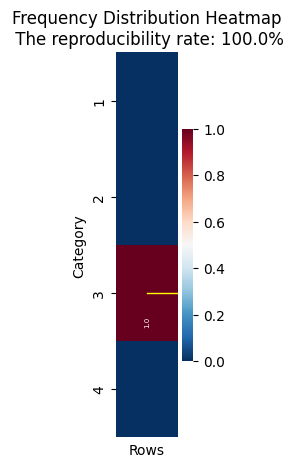

In [8]:
import seaborn as sns

# 仅选择前20行的数据
number = filtered_data_repro.shape[0]//3
repro = filtered_data_repro.iloc[:number, :]
initial = filtered_data_initial.iloc[:number, :]
# repro = filtered_data_repro
# initial = filtered_data_initial

# 创建一个矩阵来存储频率分布
frequency_matrix = np.zeros((1, 4))

# 填充频率矩阵
for i in range(1):
    row_data = repro.loc[i, :]
    unique, counts = np.unique(row_data, return_counts=True)
    frequencies = dict(zip(unique, counts))
    for category in [1, 2, 3, 4]:
        frequency_matrix[i, category - 1] = frequencies.get(category, 0) / len(row_data)

# 创建一个矩阵来存储注释（只显示值大于0的标签）
annotations = np.where(frequency_matrix > 0, np.round(frequency_matrix, 2), '')

# 绘制热力图
plt.figure(figsize=(1, 5))

ax = sns.heatmap(frequency_matrix.T, annot=annotations.T, fmt="", xticklabels=False, yticklabels=[1, 2, 3, 4], cmap="RdBu_r", cbar=True,
                 annot_kws={"size": 5, "ha": "center", "va": "center", "rotation": 90,"clip_on": True}) #cmap="viridis"

plt.title(f'Frequency Distribution Heatmap\n The reproducibility rate: {round(expected_value*100,4)}%')
plt.ylabel('Category')
plt.xlabel('Rows')

# 调整标签的位置
for text in ax.texts:
    text.set_y(float(text.get_position()[1]) + 0.3)

# 添加表示filtered_data_initial的线
initial_values = initial['new_Out0'].values - 1  # 将值转换为索引
plt.plot(np.arange(0.5, repro.shape[0] + 0.5), initial_values + 0.5, color='yellow', linewidth=1, label='Initial Value')
plt.savefig("repro-out/heatmap.svg")
plt.show()

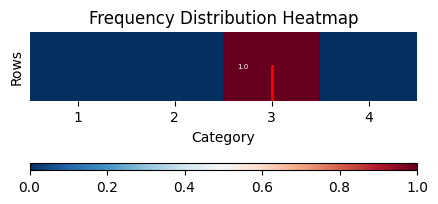

In [63]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 创建一个矩阵来存储频率分布
frequency_matrix = np.zeros((1, 4))

# 填充频率矩阵
for i in range(1):
    row_data = repro.loc[i, :]
    unique, counts = np.unique(row_data, return_counts=True)
    frequencies = dict(zip(unique, counts))
    for category in [1, 2, 3, 4]:
        frequency_matrix[i, category - 1] = frequencies.get(category, 0) / len(row_data)

# 创建一个矩阵来存储注释（只显示值大于0的标签）
annotations = np.where(frequency_matrix > 0, np.round(frequency_matrix, 2), '')

# 绘制热力图
plt.figure(figsize=(5, 2))

ax = sns.heatmap(frequency_matrix, annot=annotations, fmt="", xticklabels=[1, 2, 3, 4], yticklabels=False, cmap="RdBu_r", cbar=False,
                 annot_kws={"size": 5, "ha": "center", "va": "center", "clip_on": True})

# 添加 colorbar 在图的顶部
cbar = plt.colorbar(ax.get_children()[0], ax=ax, orientation="horizontal", pad=0.4, aspect=50)
# cbar.ax.xaxis.set_ticks_position('top')
# cbar.ax.xaxis.set_label_position('top')

# 绘制热力图

# 创建一个新的轴用于 colorbar，并将它放在热力图的顶部
# ax = sns.heatmap(frequency_matrix, annot=annotations, fmt="", xticklabels=[1, 2, 3, 4], yticklabels=False, cmap="RdBu_r", 
#                  cbar_kws={"orientation": "horizontal"}, annot_kws={"size": 5, "ha": "center", "va": "center", "clip_on": True})

# # 将 colorbar 移动到顶部
# cbar = ax.collections[0].colorbar
# cbar.ax.xaxis.set_ticks_position('top')
# cbar.ax.xaxis.set_label_position('top')

plt.title('Frequency Distribution Heatmap')
plt.xlabel('Category')
plt.ylabel('Rows')
# 调整标签的位置
for text in ax.texts:
    text.set_x(float(text.get_position()[0]) - 0.3)

# 添加表示filtered_data_initial的线
initial_values = filtered_data_initial['new_Out0'].values - 1  # 将值转换为索引
plt.plot(initial_values + 0.5, np.arange(0.5, filtered_data_repro.shape[0] + 0.5), color='red', linewidth=2, label='Initial Value')  # +0.5 to center the line



plt.show()


计算 ARI 统计量:
总误差(ARI): (0.9434, 0.9919)
随机误差(ARI): (0.9003, 1.0000)
随机覆盖总<总误差置信区间覆盖率: 1.0000；概率0.7218
随机覆盖总>总误差置信区间覆盖率: 0.4867；概率0.7218

计算 NMI 统计量:
总误差(NMI): (0.9297, 0.9857)
随机误差(NMI): (0.8883, 1.0000)
随机覆盖总<总误差置信区间覆盖率: 1.0000；概率0.721
随机覆盖总>总误差置信区间覆盖率: 0.5012；概率0.721

计算 Kappa 统计量:
总误差(Kappa): (-0.3672, 0.9846)
随机误差(Kappa): (-0.3692, 0.9956)
随机覆盖总<总误差置信区间覆盖率: 1.0000；概率0.962
随机覆盖总>总误差置信区间覆盖率: 0.9905；概率0.962


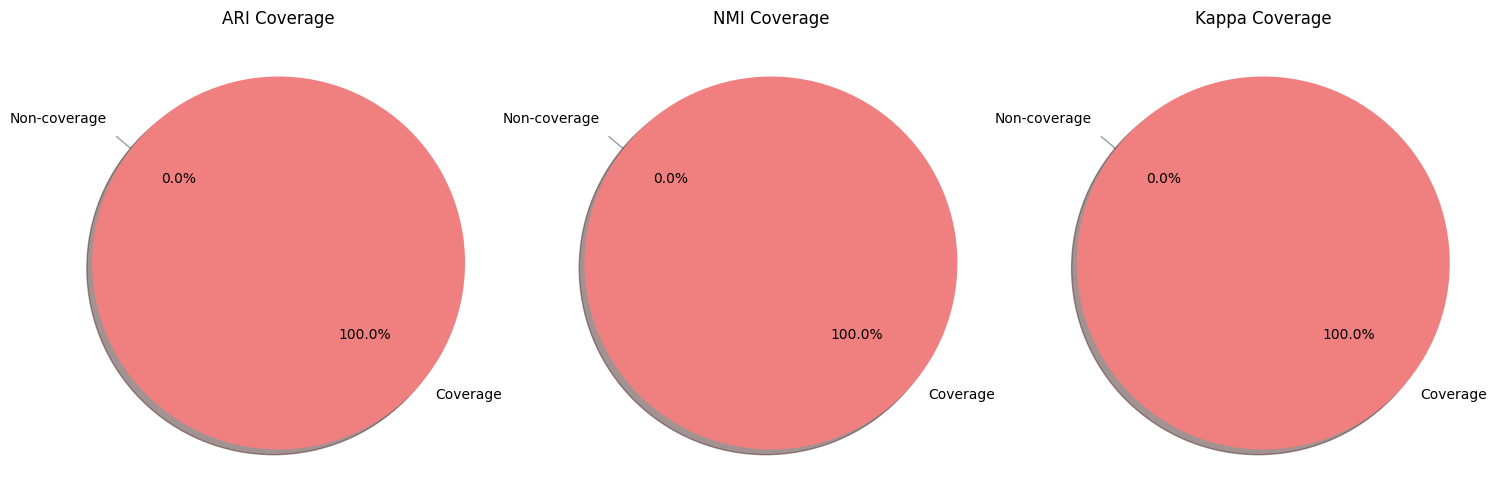

In [10]:
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, cohen_kappa_score
from itertools import combinations
import scipy.stats as stats

# 设定随机种子以确保结果一致


# 计算置信区间
def calculate_confidence_interval(values, alpha=0.05):
    values = np.sort(values)
    lower_bound = np.percentile(values, alpha / 2 * 100)
    upper_bound = np.percentile(values, (1 - alpha / 2) * 100)
    return lower_bound, upper_bound

# 蒙特卡洛抽样并计算指定类型的统计量
def monteCarloMethod(num_samples, data, stat_type):
    monteCarlo_statistics_values = []
    sampled_combinations = [np.random.choice(data.columns, 2, replace=False) for _ in range(num_samples)]
    
    for comb in sampled_combinations:
        i, j = comb
        monteCarlo_statistics_values.append(calculate_statistic_values(data[i], data[j], stat_type))
    
    return monteCarlo_statistics_values



# 计算指定类型的统计量
def calculate_statistic_values(data1, data2, stat_type):
    data1 = data1.values.ravel()  # 或者使用 data1.flatten() 
    if stat_type == "ARI":
        return adjusted_rand_score(data1, data2)
    elif stat_type == "NMI":
        return normalized_mutual_info_score(data1, data2)
    elif stat_type == "Kappa":
        return cohen_kappa_score(data1, data2)

# 计算覆盖率
def calculate_coverage(interval1, interval2):
    L1, U1 = interval1
    L2, U2 = interval2
    L_overlap = max(L1, L2)
    U_overlap = min(U1, U2)
    if L_overlap > U_overlap:
        return 0.0
    overlap_length = U_overlap - L_overlap
    length1 = U1 - L1
    coverage = overlap_length / length1
    return coverage

def calculate_coverage2(interval1, interval2):
    # interval1 总误差
    # interval2 随机误差
    L1, U1 = interval1
    L2, U2 = interval2
    L_overlap, U_overlap = max(L1, L2), min(U1, U2)
    if L_overlap > U_overlap:
        return 0.0
    overlap_length = U_overlap - L_overlap
    length1, length2 = U1 - L1, U2 - L2
    coverage = overlap_length / length2
    return coverage 
# def calculate_proportion(values, lower_bound, upper_bound):
#     # value
#     return np.sum((values >= lower_bound) & (values <= upper_bound)) / len(values)
def calculate_proportion(values, lower_bound, upper_bound):
    # 确保 values 是一个一维数组或列表
    values = np.asarray(values).flatten()
    
    common_count = 0
    total_count = len(values)
    for value in values:
        if lower_bound <= value <= upper_bound:
            common_count += 1
            
    return common_count / total_count

# 数据加载
# data_df = pd.read_csv('repro-out/filtered_data.csv')
# filtered_data_repro = data_df[[f'new_Out{i}' for i in range(1, 1001)]]
# out0 = data_df['new_Out0']

# 生成示例数据
data_df = pd.read_csv("./repro-out/pred_nonoisy.csv")
filtered_data_repro = data_df[[f'Out{i}' for i in range(1, 1001)]]

out0 = data_df["Out0"]=data_df["cluster"]=pd.read_csv("./initial-out/pred_nonoisy_initial.csv")

# 定义要计算的统计量类型
stat_types = ["ARI", "NMI", "Kappa"]  # 可选值："ARI", "NMI", "Kappa"


fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for idx, stat_type in enumerate(stat_types):
    print(f"\n计算 {stat_type} 统计量:") 
    # 计算原始结果与复现结果的指定统计量
    real_values = [calculate_statistic_values(out0, filtered_data_repro[f'Out{i}'], stat_type) for i in range(1, 1001)]
    # 计算置信区间-----总误差
    ci_low, ci_high = calculate_confidence_interval(real_values)
    # -----随机误差
    monteCarlo_values = monteCarloMethod(10000, filtered_data_repro, stat_type)
    ci_low_mc_random, ci_high_mc_random = calculate_confidence_interval(monteCarlo_values)
    print(f"总误差({stat_type}): ({ci_low:.4f}, {ci_high:.4f})")
    print(f"随机误差({stat_type}): ({ci_low_mc_random:.4f}, {ci_high_mc_random:.4f})")
    # 计算覆盖率

    ratio_original = calculate_proportion(monteCarlo_values, ci_low, 1)


    coverage = calculate_coverage((ci_low, ci_high), (ci_low_mc_random, ci_high_mc_random))
    coverage2 = calculate_coverage2((ci_low, ci_high), (ci_low_mc_random, ci_high_mc_random))
    print(f"随机覆盖总<总误差置信区间覆盖率: {coverage:.4f}；概率{ratio_original}")
    print(f"随机覆盖总>总误差置信区间覆盖率: {coverage2:.4f}；概率{ratio_original}")

     # 绘制覆盖率的饼图
    
    # labels = ['Coverage', 'Non-coverage']
    # sizes = [coverage, 1-coverage]
    # colors = ['lightcoral', 'lightskyblue']
    # explode = (0.1, 0)  # 突出显示覆盖率
    # ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
    #        shadow=True, startangle=140)
    # ax.axis('equal')
        # 绘制覆盖率的饼图
    labels = ['Coverage', 'Non-coverage']
    sizes = [coverage, 1-coverage]
    colors = ['lightcoral', 'lightskyblue']
    explode = (0.1, 0)  # 突出显示覆盖率
    axs[idx].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
                 shadow=True, startangle=140)
    axs[idx].axis('equal')
    axs[idx].set_title(f'{stat_type} Coverage')

plt.title(f'{stat_type} Coverage')
plt.show()


In [11]:
from sklearn.metrics import (
    adjusted_rand_score, 
    adjusted_mutual_info_score, 
    homogeneity_completeness_v_measure, 
    fowlkes_mallows_score, 
    jaccard_score
)

def calculate_clustering_similarity(true_labels, predicted_labels):
    similarity_measures = {
        "Adjusted Rand Index": adjusted_rand_score,
        "Adjusted Mutual Information": adjusted_mutual_info_score,
        "Homogeneity": lambda x, y: homogeneity_completeness_v_measure(x, y)[0],
        "Completeness": lambda x, y: homogeneity_completeness_v_measure(x, y)[1],
        "V-Measure": lambda x, y: homogeneity_completeness_v_measure(x, y)[2],
        "Fowlkes-Mallows Index": fowlkes_mallows_score,
        "Jaccard Index": lambda x, y: jaccard_score(
            [1 if label == 0 else 0 for label in x], 
            [1 if label == 0 else 0 for label in y]
        )  # Example for binary case, adjust accordingly for multi-class
    }
    
    results = {}
    for measure_name, measure_func in similarity_measures.items():
        results[measure_name] = measure_func(true_labels, predicted_labels)
    
    return results

# 示例聚类标签
labels_true = out0
labels_pred = data["Out18"]

# 确保标签是1D的
labels_true = labels_true.values.ravel()
labels_pred = labels_pred.values.ravel()

# 计算相似性
similarity_results = calculate_clustering_similarity(labels_true, labels_pred)

# 打印结果
for measure, result in similarity_results.items():
    print(f"{measure}: {result:.4f}")

Adjusted Rand Index: 0.9434
Adjusted Mutual Information: 0.9293
Homogeneity: 0.9276
Completeness: 0.9318
V-Measure: 0.9297
Fowlkes-Mallows Index: 0.9589
Jaccard Index: 0.0000
